<a href="https://colab.research.google.com/github/Safa06/Thesis/blob/main/IP(new-100).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Libraries**

In [3]:
# VGG16
#import cv2
import tensorflow as tf
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
#from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.decomposition import PCA
import scipy.io
from scipy.io import loadmat
#from skimage.transform import resize
from keras.applications.vgg16 import preprocess_input
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score,recall_score,f1_score
from sklearn.metrics import classification_report
from keras.callbacks import ModelCheckpoint

# **Data Load**

In [4]:
# DATA load
mat_data1= scipy.io.loadmat('Indian_pines_corrected.mat')
mat_data2=scipy.io.loadmat('Indian_pines_gt.mat')
X=mat_data1['indian_pines_corrected']
y=mat_data2['indian_pines_gt']
print(X.shape)
print(y.shape)

(145, 145, 200)
(145, 145)


# **Apply PCA,PADDING**

In [5]:
# Apply PCA to minimize band from 200 to 3 band
def applyPCA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

K = 3
X,pca= applyPCA(X,numComponents=K)
print(X.shape, y.shape)



#padding with zero
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX


(145, 145, 3) (145, 145)


# **Create Patches**

In [6]:
# Window for patches
windowSize=23
def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

X, y = createImageCubes(X, y, windowSize=windowSize)
#print(X.shape,y.shape)

# **Train-test split**

In [7]:
#Split train-test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)


(7174, 23, 23, 3) (3075, 23, 23, 3) (7174,) (3075,)


# **Model**

In [8]:
S = windowSize
L = K
#output_units = 9 if (dataset == 'PU' or dataset == 'PC') else 16

## input layer
input_layer = (23,23,3)

#for 3D CNN--input_layer=Input(S, S, L, 1)

#Model
model = Sequential()

#Block 1

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu',padding="same",input_shape=(23,23,3)))
model.add(Conv2D(64, kernel_size=(3,3), activation='relu',padding="same"))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Block 2
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Block 3
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Block 4
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Block 5
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
#model.add(MaxPooling2D((2, 2), strides=(2, 2)))
model.add(MaxPooling2D((1, 1), strides=(1, 1)))

# Fully connected layers
model.add(Flatten())
model.add(Dense(units=4096, activation='relu'))
model.add(Dense(units=4096, activation='relu'))
model.add(Dense(units=16, activation='softmax'))

model.build()
model.summary()


model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 23, 23, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 23, 23, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 11, 11, 64)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 11, 11, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 11, 11, 128)       147584    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 128)         0         
 g2D)                                                   

# **Epoch starts**

In [9]:
# checkpoint for saving epochs
filepath = "best-model.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test,y_test),batch_size=32,callbacks=callbacks_list)

Epoch 1/100
225/225 [==============================] - ETA: 0s - loss: 2.0136 - accuracy: 0.3012
Epoch 1: accuracy improved from -inf to 0.30123, saving model to best-model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


225/225 [==============================] - 20s 46ms/step - loss: 2.0136 - accuracy: 0.3012 - val_loss: 1.4080 - val_accuracy: 0.4156
Epoch 2/100
225/225 [==============================] - ETA: 0s - loss: 1.1403 - accuracy: 0.5539
Epoch 2: accuracy improved from 0.30123 to 0.55394, saving model to best-model.hdf5
225/225 [==============================] - 10s 42ms/step - loss: 1.1403 - accuracy: 0.5539 - val_loss: 0.8887 - val_accuracy: 0.6738
Epoch 3/100
224/225 [============================>.] - ETA: 0s - loss: 0.6929 - accuracy: 0.7320
Epoch 3: accuracy improved from 0.55394 to 0.73209, saving model to best-model.hdf5
225/225 [==============================] - 10s 44ms/step - loss: 0.6926 - accuracy: 0.7321 - val_loss: 0.5089 - val_accuracy: 0.8114
Epoch 4/100
225/225 [==============================] - ETA: 0s - loss: 0.4072 - accuracy: 0.8627
Epoch 4: accuracy improved from 0.73209 to 0.86270, saving model to best-model.hdf5
225/225 [==============================] - 9s 39ms/step - 

# **Graph**

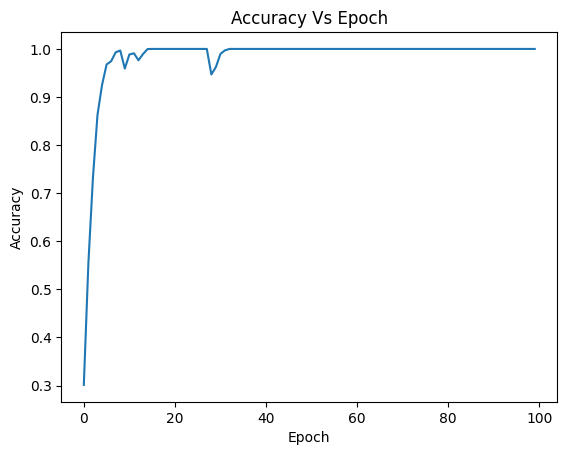

<Figure size 640x480 with 0 Axes>

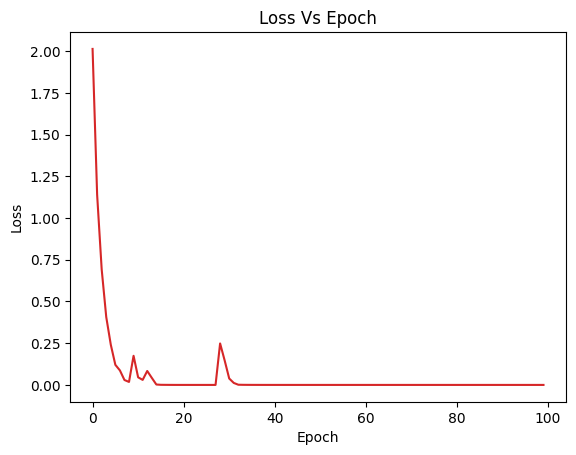

<Figure size 640x480 with 0 Axes>

In [11]:
plt.figure()
plt.plot(history.history['accuracy'],color ='tab:blue')
plt.title('Accuracy Vs Epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()
plt.savefig('Accuracy_Vs_Epoch.png',dpi=300)

plt.figure()
plt.plot(history.history['loss'],color ='tab:red')
plt.title('Loss Vs Epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()
plt.savefig('Loss_Vs_Epoch.png',dpi=300)

# **Testing & Confusion matrix**

97/97 - 1s - loss: 0.0259 - accuracy: 0.9974 - 716ms/epoch - 7ms/step
97/97 [==============================] - 1s 6ms/step
(3075,) (3075, 16) (3075,)
[[ 22   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0 407   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0 248   0   0   0   0   0   0   3   0   2   0   0   0   0]
 [  0   0   0  61   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0 137   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0 222   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   9   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0 133   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   4   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0 315   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0 719   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0 189   0   0   0   2]
 [  0   0   0   0   0   0   0   0   0   0   0 

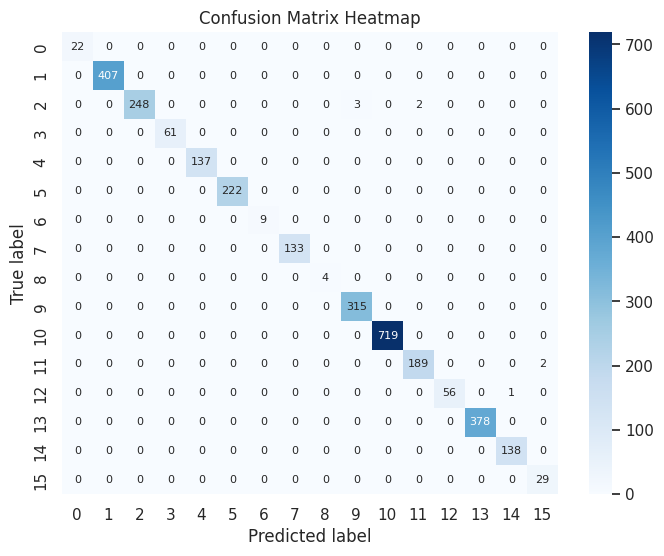

<Figure size 640x480 with 0 Axes>

In [12]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)

# Generate predictions on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred,axis=1)
print(y_test.shape,y_pred.shape,y_pred_classes.shape)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Print the confusion matrix
print(conf_matrix)


#Confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.set(font_scale=1)  # Adjust font scale if needed
sns.heatmap(conf_matrix, cmap='Blues', annot=True, annot_kws={"size": 8}, fmt='d')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix Heatmap')
plt.show()
plt.savefig('Conf_matrix_heatmap.png',dpi=300)

# **Precision, Recall, F1 Score**

In [13]:
# precision = precision_score(y_test,y_pred_classes)
# recall = recall_score(y_test,y_pred_classes)
# f1 = f1_score(y_test,y_pred_classes)

# print('Classification Report')
# print("Precision: ",precision)
# print("Recall: ",recall)
# print("F1 Score: ",f1)


report = classification_report(y_test,y_pred_classes)
print(report)


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        22
         1.0       1.00      1.00      1.00       407
         2.0       1.00      0.98      0.99       253
         3.0       1.00      1.00      1.00        61
         4.0       1.00      1.00      1.00       137
         5.0       1.00      1.00      1.00       222
         6.0       1.00      1.00      1.00         9
         7.0       1.00      1.00      1.00       133
         8.0       1.00      1.00      1.00         4
         9.0       0.99      1.00      1.00       315
        10.0       1.00      1.00      1.00       719
        11.0       0.99      0.99      0.99       191
        12.0       1.00      0.98      0.99        57
        13.0       1.00      1.00      1.00       378
        14.0       0.99      1.00      1.00       138
        15.0       0.94      1.00      0.97        29

    accuracy                           1.00      3075
   macro avg       0.99   

# **Classification report shows**

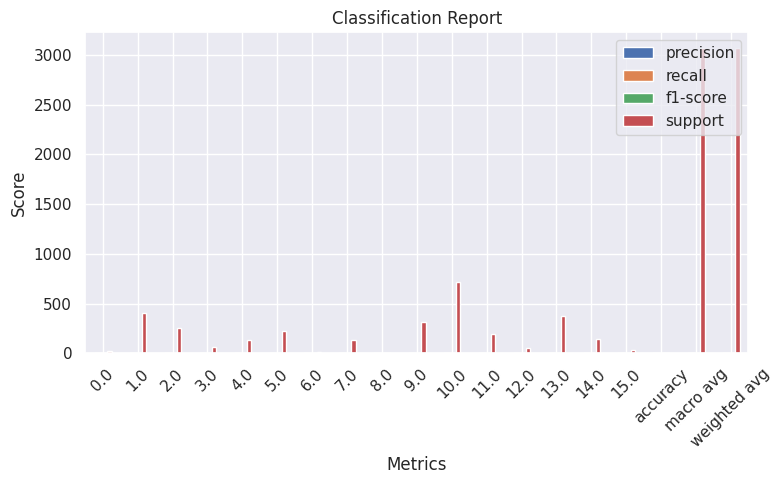

In [14]:
report = classification_report(y_test, y_pred_classes, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Plot the classification report
fig, ax = plt.subplots(figsize=(8, 5))
report_df.plot(kind='bar', ax=ax)
plt.title('Classification Report')
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()